## Goal of the project: 
Find out factors that affects the overall satisfaction of airline passengers to better reallocate resources to make customers happy.

## Workflow:
1. Audit and clean the data
2. Use visualization to find out potential factors that could affect the possibility of airline passengers' being happy.
3. Test the significance of those factors in a logistic regression
4. Build a ML algorithm to predict if a customer is satisfied

This notebook will achieve the last two part of the workflow

### Import my toolkit

In [1]:
import os
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import time
from datetime import datetime
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import sklearn
from collections import Counter
from scipy.stats import kruskal, pearsonr, spearmanr, chi2_contingency, f_oneway
from scipy.stats import kurtosis, skew, probplot, boxcox, boxcox_normplot
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.decomposition import NMF, LatentDirichletAllocation
from scipy.stats import pearsonr,spearmanr,gaussian_kde
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from nltk.stem import WordNetLemmatizer
import re
from datetime import timedelta 
from statsmodels.stats.outliers_influence import variance_inflation_factor
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo
import statsmodels.api as sm
import xgboost as xgb
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix

### Import dataset

In [2]:
df=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

### Review the findings
1. For personal passengers, flight distance seem to have no association with satisfaction.


2. For business passengers, flight distance seems to associate with a negative impact on satisfaction level if not business class; but satisfied passengers seem to enjoy long flight if they are at business class.


3. Both arrival delay and departure delay negatively associate with satisfaction level.


4. Gender does not seem to distinguish satisfied customers.


5. Loyal Customers seem to be more likely to be satisfied.


6. Most Happy customers are from the Business Class.


7. Business Traveller are more likely to be satisfied.


8. Almost high scores of all items associate with higher satisfaction level, except for departure/arrival time convenience.


9. The graph shows that Customers aged below 22 and above 61 are "difficult customers" who are more likely to be neutral or dissatisfied. Customers aged between 23 and 38 are normal customers in terms of satisfaction. Customers aged between 39 and 60 are relatively satisfied.


10. Among all the items, these associate more with higher satisfaction level of business class passengers than other classes:

 Seat comfort;
 On-board service;
 Leg room service;
 Baggages handling;
 Checkin service;

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103904 entries, 0 to 103903
Data columns (total 25 columns):
Unnamed: 0                           103904 non-null int64
id                                   103904 non-null int64
Gender                               103904 non-null object
Customer Type                        103904 non-null object
Age                                  103904 non-null int64
Type of Travel                       103904 non-null object
Class                                103904 non-null object
Flight Distance                      103904 non-null int64
Inflight wifi service                103904 non-null int64
Departure/Arrival time convenient    103904 non-null int64
Ease of Online booking               103904 non-null int64
Gate location                        103904 non-null int64
Food and drink                       103904 non-null int64
Online boarding                      103904 non-null int64
Seat comfort                         103904 non-null int64


### 3. Data cleaning, feature engineering, and multicolinearity checking

In [4]:
# First, we need to drop missing values and the first column
df=df.iloc[:,1:]
df=df[df['Arrival Delay in Minutes'].notnull()]

In [5]:
df.head()

,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [6]:
# Next, we need to create 4 age bins, as we found out that customers in four age stages are of different satisfaction level
def binage(x):
    if x<22:
        return 'less 22'
    elif x<39:
        return '22 to 38'
    elif x<61:
        return '39 to 60'
    else:
        return 'more 60'
    
df['Age Bins']=df['Age'].apply(binage)

In [7]:
# Next, we need to create dummy variables for categorical variables
df=pd.get_dummies(df,columns=['Gender','Customer Type','Type of Travel','Class','Age Bins'],drop_first=True)
df['satisfaction'].replace({'neutral or dissatisfied': 0, 'satisfied': 1},inplace = True)

In [8]:
df.columns

Index(['id', 'Age', 'Flight Distance', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'Cleanliness', 'Departure Delay in Minutes', 'Arrival Delay in Minutes',
       'satisfaction', 'Gender_Male', 'Customer Type_disloyal Customer',
       'Type of Travel_Personal Travel', 'Class_Eco', 'Class_Eco Plus',
       'Age Bins_39 to 60', 'Age Bins_less 22', 'Age Bins_more 60'],
      dtype='object')

In [9]:
# Then we drop departure/arrival time convenient, as it has no association with satisfaction level
df.drop(columns=['Departure/Arrival time convenient'],inplace=True)

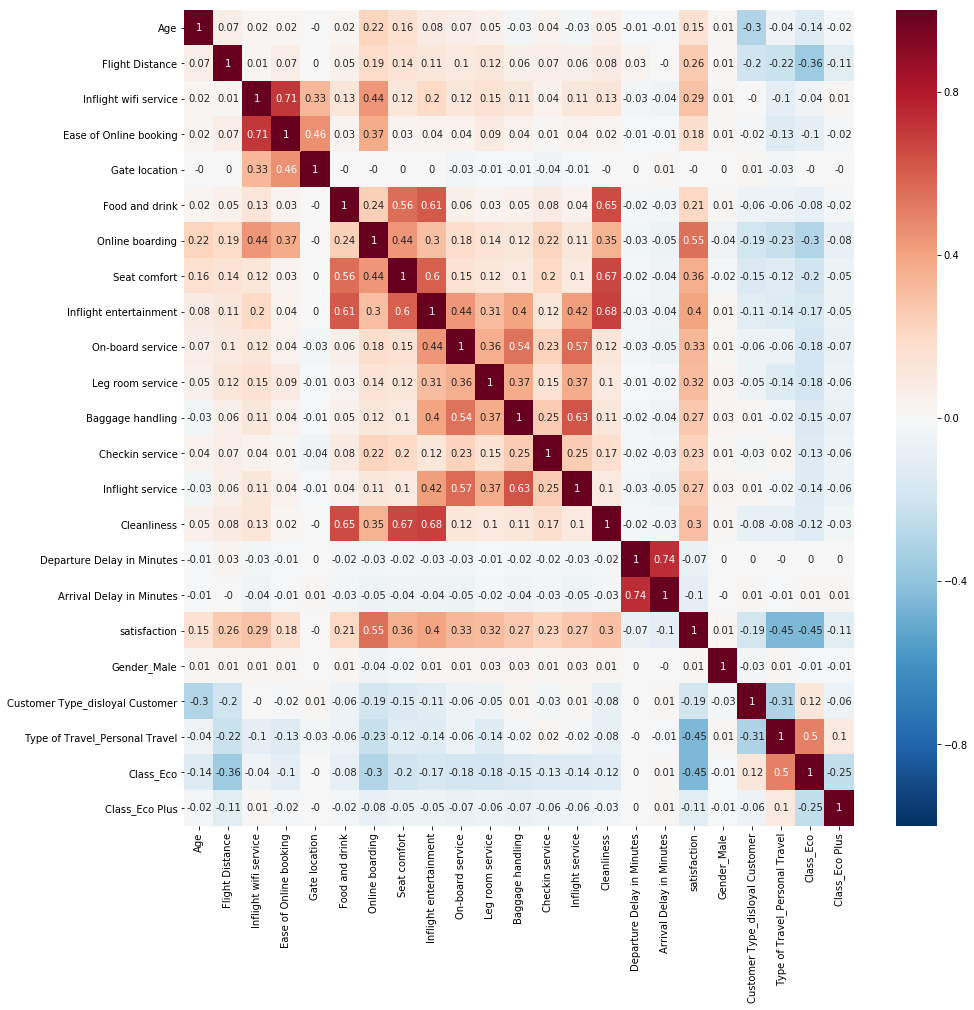

In [10]:
# Next, we check multicolinearity by looking at the heat map
plt.subplots(1, 1, figsize=(15, 15))
sns.heatmap(df.drop(columns=['id','Age Bins_39 to 60', 'Age Bins_less 22', 'Age Bins_more 60']).corr(method='spearman').round(2),
           cmap='RdBu_r', annot=True,vmin=-1,vmax=1)

In [11]:
# Even before using the VIF method, we can see that the arrival and departure delay is colinear
# So we can just create a new feature: Mean Delay
df['Mean Delay']=0.5*(df['Departure Delay in Minutes']+df['Arrival Delay in Minutes'])
df.drop(columns=['Departure Delay in Minutes','Arrival Delay in Minutes'],inplace=True)

In [12]:
# And we can use the VIF method to test for multicolinearity
vif_data = pd.DataFrame() 
vif_data["feature"] = df.drop(columns=['id','Age','satisfaction']).columns 
vif_data["VIF"] = [variance_inflation_factor(df.drop(columns=['id','Age','satisfaction']).values,\
i) for i in range(len(df.drop(columns=['id','Age','satisfaction']).columns))] 

In [13]:
print(vif_data)

                            feature        VIF
0                   Flight Distance   3.047525
1             Inflight wifi service  12.694169
2            Ease of Online booking  12.370557
3                     Gate location   8.017179
4                    Food and drink  14.119457
5                   Online boarding  12.907068
6                      Seat comfort  18.243048
7            Inflight entertainment  27.336472
8                  On-board service  13.755004
9                  Leg room service   9.473416
10                 Baggage handling  19.363653
11                  Checkin service   9.320462
12                 Inflight service  21.194778
13                      Cleanliness  20.695941
14                      Gender_Male   1.951852
15  Customer Type_disloyal Customer   1.828807
16   Type of Travel_Personal Travel   3.018955
17                        Class_Eco   3.310052
18                   Class_Eco Plus   1.284961
19                Age Bins_39 to 60   2.645609
20           

Okay, so all the survey scale features have the multicolinearity problem, which means different questions measure the same things. So we will use PCA to process the survey scale questions.

### Principle Component Analysis

In [14]:
# First, we separate survey scale features from other features
df_pca=df[['Inflight wifi service','Ease of Online booking', 'Gate location', 'Food and drink',\
          'Online boarding', 'Seat comfort', 'Inflight entertainment',\
'On-board service', 'Leg room service', 'Baggage handling',\
'Checkin service', 'Inflight service', 'Cleanliness']]

In [15]:
# Then we conduct the Bartlett Sphericity and KMO test
chi_square_value,p_value=calculate_bartlett_sphericity(df_pca)
print(chi_square_value, p_value)
kmo_all,kmo_model=calculate_kmo(df_pca)
print(kmo_model)

563105.0625849504 0.0
0.7747348061790389


P-value is 0, and KMO value is larger than 0.6, so we can do PCA

In [16]:
fa=FactorAnalyzer(rotation=None,n_factors=3)
factor_df=fa.fit_transform(df_pca)
loadingsDF=pd.DataFrame(fa.loadings_,index=list(df_pca.columns), columns=['Factor 1','Factor 2','Factor 3'])
loadingsDF

,Factor 1,Factor 2,Factor 3
Inflight wifi service,0.408863,0.686554,-0.096494
Ease of Online booking,0.286126,0.904742,-0.131067
Gate location,0.077146,0.411584,-0.071723
Food and drink,0.585225,-0.225419,-0.419227
Online boarding,0.473288,0.258863,-0.184684
Seat comfort,0.660748,-0.215083,-0.385803
Inflight entertainment,0.848087,-0.226296,-0.045396
On-board service,0.487514,-0.034584,0.511569
Leg room service,0.361791,0.049988,0.338211
Baggage handling,0.470162,-0.020090,0.603649


In [17]:
fa.get_eigenvalues()

(array([3.77281848, 2.16735357, 2.06881829, 1.01790569, 0.84267693,
        0.70018861, 0.51527809, 0.47395591, 0.36841596, 0.32937293,
        0.29603555, 0.25687594, 0.19030404]),
 array([ 3.38351831e+00,  1.75524609e+00,  1.73226157e+00,  3.21929864e-01,
         1.04648015e-01,  4.12312792e-02,  8.94722190e-03, -1.36837122e-03,
        -1.02541479e-02, -2.25278274e-02, -4.78896842e-02, -1.54109264e-01,
        -2.40606790e-01]))

According to the Eigen values and the ease with interpretation, having three factors is optimal.
According to the factor loading, the first factor is mostly associated with infrastructure of the plane, such as seat comfort, entertainment, food and drink, and cleanliness. The second factor is mostly associated with good internet service and bad infrastructure. The third factor is mostly associated with good human interactive service and bad infrastructure.

In [18]:
factor_df = pd.DataFrame(factor_df,columns=['Good plane infrastructure', 'Good internet', 'Good service']) 

In [19]:
# Merge the new table with the old
df.reset_index(inplace=True)
factor_df=pd.merge(factor_df,df[[ 'Flight Distance',
       'Gender_Male', 'Customer Type_disloyal Customer',
       'Type of Travel_Personal Travel', 'Class_Eco', 'Class_Eco Plus',
       'Age Bins_39 to 60', 'Age Bins_less 22', 'Age Bins_more 60', 'Mean Delay','satisfaction']],left_index=True,right_index=True,how='left')

In [20]:
# Use VIF to check again
vif_data = pd.DataFrame() 
vif_data["feature"] = factor_df.drop(columns=['satisfaction']).columns 
vif_data["VIF"] = [variance_inflation_factor(factor_df.drop(columns=['satisfaction']).values,\
i) for i in range(len(factor_df.drop(columns=['satisfaction']).columns))] 
print(vif_data)

                            feature       VIF
0         Good plane infrastructure  1.098711
1                     Good internet  1.008139
2                      Good service  1.039017
3                   Flight Distance  1.946695
4                       Gender_Male  1.783281
5   Customer Type_disloyal Customer  1.483328
6    Type of Travel_Personal Travel  2.743763
7                         Class_Eco  3.128635
8                    Class_Eco Plus  1.233919
9                 Age Bins_39 to 60  1.963594
10                 Age Bins_less 22  1.391843
11                 Age Bins_more 60  1.234207
12                       Mean Delay  1.140701


Nice, there seems to have no multicolinearity problem, as all VIF values are below 5

### Logistic Regression

In [21]:
# Model 1
x=factor_df.drop(columns='satisfaction')
y=factor_df['satisfaction']
x=sm.add_constant(x)

In [22]:
model1 = sm.Logit(y, x).fit()

Optimization terminated successfully.
         Current function value: 0.375857
         Iterations 7


In [23]:
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           satisfaction   No. Observations:               103594
Model:                          Logit   Df Residuals:                   103580
Method:                           MLE   Df Model:                           13
Date:                Tue, 01 Dec 2020   Pseudo R-squ.:                  0.4507
Time:                        10:35:49   Log-Likelihood:                -38936.
converged:                       True   LL-Null:                       -70884.
                                        LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               1.0974      0.029     38.120      0.000       1.041       1.154
Good plane infrastructure           1.3981      0.012    121.359      0.000       1.376       1.421
Good internet                       0.1099      0.009     11.842      0.000       0.092       0.128
Good service                        0.2926      0.011     27.167      0.000       0.272       0.314
Flight Distance                 -4.802e-06   1.05e-05     -0.456      0.649   -2.55e-05    1.59e-05
Gender_Male                         0.0171      0.018      0.943      0.346      -0.018       0.053
Customer Type_disloyal Customer    -1.8785      0.027    -70.743      0.000      -1.931      -1.826
Type of Travel_Personal Travel     -2.6759      0.028    -94.462      0.000      -2.731      -2.620
Class_Eco                          -0.9075      0.023    -39.005      0.000      -0.953      -0.862
Class_Eco Plus                     -0.9988      0.038    -26.569      0.000      -1.073      -0.925
Age Bins_39 to 60                   0.2785      0.021     13.288      0.000       0.237       0.320
Age Bins_less 22                    0.1001      0.032      3.143      0.002       0.038       0.163
Age Bins_more 60                   -0.4386      0.040    -10.913      0.000      -0.517      -0.360
Mean Delay                         -0.0038      0.000    -15.547      0.000      -0.004      -0.003
===================================================================================================
"""

It seems that Flight Distance and Gender are not good predictors, and from the visualization we get that flight distance only matters when it concerns the type of travel and class. So we create a new feature: flight distance * Business travel * Business Class. Also, we will then drop flight distance and gender in our model 2.

In [24]:
factor_df['Distance_Business']=factor_df['Flight Distance']*(1-factor_df['Type of Travel_Personal Travel'])\
*(1-factor_df['Class_Eco']-factor_df['Class_Eco Plus'])
factor_df.drop(columns=['Flight Distance','Gender_Male'],inplace=True)

In [25]:
# Model 2
x=factor_df.drop(columns='satisfaction')
y=factor_df['satisfaction']
x=sm.add_constant(x)
model2 = sm.Logit(y, x).fit()

Optimization terminated successfully.
         Current function value: 0.375836
         Iterations 7


In [26]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:           satisfaction   No. Observations:               103594
Model:                          Logit   Df Residuals:                   103581
Method:                           MLE   Df Model:                           12
Date:                Tue, 01 Dec 2020   Pseudo R-squ.:                  0.4507
Time:                        10:35:50   Log-Likelihood:                -38934.
converged:                       True   LL-Null:                       -70884.
                                        LLR p-value:                     0.000
===================================================================================================
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                               1.0514      0.028     37.499      0.000       0.996       1.106
Good plane infrastructure           1.3979      0.012    121.326      0.000       1.375       1.420
Good internet                       0.1106      0.009     11.914      0.000       0.092       0.129
Good service                        0.2931      0.011     27.218      0.000       0.272       0.314
Customer Type_disloyal Customer    -1.8579      0.027    -69.677      0.000      -1.910      -1.806
Type of Travel_Personal Travel     -2.6619      0.029    -92.744      0.000      -2.718      -2.606
Class_Eco                          -0.8671      0.027    -32.179      0.000      -0.920      -0.814
Class_Eco Plus                     -0.9536      0.040    -23.608      0.000      -1.033      -0.874
Age Bins_39 to 60                   0.2793      0.021     13.327      0.000       0.238       0.320
Age Bins_less 22                    0.0984      0.032      3.090      0.002       0.036       0.161
Age Bins_more 60                   -0.4366      0.040    -10.863      0.000      -0.515      -0.358
Mean Delay                         -0.0038      0.000    -15.555      0.000      -0.004      -0.003
Distance_Business                 2.64e-05   1.15e-05      2.305      0.021    3.95e-06    4.88e-05
===================================================================================================
"""

In [27]:
def deviance(X, y, model):
    return 2*sklearn.metrics.log_loss(y, model.predict(X), normalize=False)

In [28]:
deviance(x,y,model2)

77868.76885536914

The model has a lager log-likelihood, and the deviance over residual df is close to 1, so this descriptive model is acceptable.

Conclusion: Factors that increase the probability of being satisfied within 99% confidence interval:
1. Good plane infrastructure (Which is more important than good internet and good service)
2. Good internet
3. Good service
4. Being a loyal customer
5. Being on a Business Travel (Could be the most important factor)
6. Being in the business class
7. Aged between 39 and 60
8. Aged below 22
9. Less delay

### 4. ML algorithm for classification

It would be natural to think of using tree-based model for this binary classification problem, as the potential interaction between features are countless. For example, we know that when a customer is business travel + business class, long distance could be good for satisfaction, but when the situation is business travel + ECO class, long distance has the reverse effect. Thus, Using tree based algorithm could learn these interactions much quicker.


So for other algorithms, such as logistic regression, to capture all this interactions, there will be countless combination of features we would need to try. Also, by using tree based algorithm, we would not have to sacrifice the explanation power by conducting dimension reduction,

Thus, we will try 3 algorithms: Random Forest, XGboost, and LGBM.

In [29]:
df.columns

Index(['index', 'id', 'Age', 'Flight Distance', 'Inflight wifi service',
       'Ease of Online booking', 'Gate location', 'Food and drink',
       'Online boarding', 'Seat comfort', 'Inflight entertainment',
       'On-board service', 'Leg room service', 'Baggage handling',
       'Checkin service', 'Inflight service', 'Cleanliness', 'satisfaction',
       'Gender_Male', 'Customer Type_disloyal Customer',
       'Type of Travel_Personal Travel', 'Class_Eco', 'Class_Eco Plus',
       'Age Bins_39 to 60', 'Age Bins_less 22', 'Age Bins_more 60',
       'Mean Delay'],
      dtype='object')

In [30]:
df=df.drop(columns=['index', 'id','Age'])

In [31]:
X=df.drop(columns='satisfaction')
y=df['satisfaction']

In [32]:
# Train - validation split
xtrain, xvalid, ytrain, yvalid = train_test_split(X, y, random_state=7, 
                                                  test_size=0.2)

In [33]:
def fit_and_report(model, X_train, y_train, X_test, y_test, verbose=True):
    if verbose == False:
        model.fit(X_train,y_train, verbose=0)
    else:
        model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    print(classification_report(y_test,y_pred,digits=5))
    sns.heatmap(confusion_matrix(y_test,y_pred).round(),annot=True)

    
    return model

              precision    recall  f1-score   support

           0    0.94370   0.95574   0.94968     11681
           1    0.94184   0.92631   0.93401      9038

    accuracy                        0.94290     20719
   macro avg    0.94277   0.94103   0.94185     20719
weighted avg    0.94289   0.94290   0.94285     20719



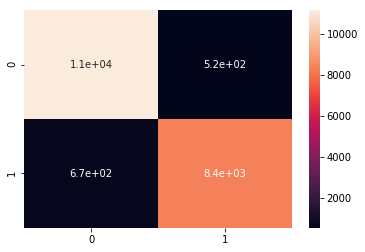

In [34]:
# Random Forest Classifier
al_rf = RandomForestClassifier(max_depth= 10,
         min_samples_leaf= 1,
         min_samples_split= 2,
         n_estimators= 1000)
al_rf = fit_and_report(al_rf, xtrain, ytrain, xvalid, yvalid)

              precision    recall  f1-score   support

           0    0.95768   0.97243   0.96500     11681
           1    0.96365   0.94446   0.95396      9038

    accuracy                        0.96023     20719
   macro avg    0.96066   0.95845   0.95948     20719
weighted avg    0.96028   0.96023   0.96018     20719



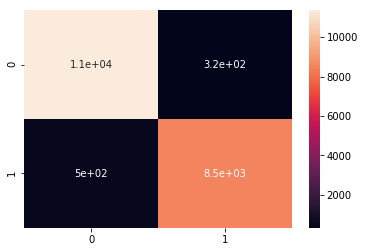

In [35]:
# XGBoost
al_xgb = xgb.XGBClassifier(max_depth=25, n_estimators=1000, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1)
al_xgb=fit_and_report(al_xgb, xtrain, ytrain, xvalid, yvalid)

              precision    recall  f1-score   support

           0    0.95779   0.97526   0.96645     11681
           1    0.96725   0.94446   0.95572      9038

    accuracy                        0.96182     20719
   macro avg    0.96252   0.95986   0.96108     20719
weighted avg    0.96192   0.96182   0.96177     20719



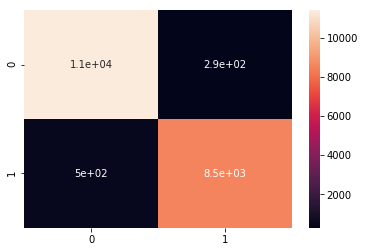

In [36]:
# LGBM
al_gbm = lgb.LGBMClassifier(max_depth=25,
                           num_leaves=25,
                        learning_rate=0.1,
                        n_estimators=1000)
al_gbm=fit_and_report(al_gbm, xtrain, ytrain, xvalid, yvalid)

### Conclusion:

Performances of three models are close, and the accuracy is around 96%, and type 2 error is harder to avoid than type 1 error.

Since the performance of LGBM model is slightly better than other two, according to weighted average accuracy, LGBM model should be selected.